In [1]:
import cedalion
import cedalion.nirs
import numpy as np
import xarray as xr
import pint
import matplotlib.pyplot as p
import scipy.signal
import os.path

# Loading SNIRF data

This notebook uses a finger-tapping dataset in BIDS layout. Download it [here](https://github.com/rob-luke/BIDS-NIRS-Tapping) and point the variable `DATADIR` to its location.

In [2]:
DATADIR = "/home/eike/Projekte/ibslab/30_dev/data/BIDS-NIRS-Tapping"



In its current implementation `read_snirf` extracts three things:
- geo is a `xr.DataArray` that stores for coordinates of labeled points (e.g. 'S1', 'D1, 'CZ')
- das is a list of `xr.DataArray` that contain the /nirs(i)/data(j)/dataTimeSeries arrays
- stim is a `pd.DataFrame` that contains event information

In [3]:
#geo, das, stim = cedalion.io.read_snirf("/home/eike/Projekte/ibslab/30_dev/data/BIDS-NIRS-Tapping/sub-01/nirs/sub-01_task-tapping_nirs.snirf")[0]
elements = cedalion.io.read_snirf(os.path.join(DATADIR, "sub-01/nirs/sub-01_task-tapping_nirs.snirf"))
elem = elements[0] # there is only one NirsElement in this snirf file

Proposal: Use xarray's `DataArray` the main container for data in memory.

Note about the term 'channel'. I deviate from the convention that is used in SNIRF and MNE. These toolboxes consider "S1D1 760nm" and "S1D1 850nm" or "S1D1 HbO" and "S1D1 HbR" as different channels. I would propose a wording in which "S1D1" denotes a channel that comprises multiple components. These components could be for example  different wavelengths or different chromophores. In the context of source separation techniques these components will be futher split up. As will be shown, it is advantageous to keep extra dimensions for these components.


recorded time series:

In [4]:
da = elem.data[0] # there is only one data element with amplitude data in this NIRS element. 
da

Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0941083 0.0940129 0.0944882] [0.1856806 0.186377 0.1836514 ... 0.1856486 0.1850836 0.1842172]] [[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] ... [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]] [[0.4885007 0.4802285 0.4818338 ... 0.6109142 0.6108118 0.613845] [0.8457658 0.825988 0.8259648 ... 0.975894 0.9756599 0.9826459]] [[0.6304559 0.6284427 0.6287045 ... 0.6810626 0.6809573 0.6818709] [1.2285622 1.2205907 1.2190002 ... 1.2729124 1.2727222 1.2755645]]]
Units,dimensionless


Source, detector and landmark positions:

In [5]:
elem.geo3d

Magnitude,[[-0.041613204679326624 0.026799775287857947 0.1299043936308115] [-0.06476686499872276 0.05814256998996063 0.0908425773727145] [-0.07120554551675068 -0.012874272652217859 0.10787860947691345] [-0.0859043654400404 0.018971698468891116 0.06509762433137256] [0.03694171596700852 0.02748380530252158 0.13022129709104263] [0.06065133742692848 0.05882414589197514 0.09117717995727878] [0.06712771392323756 -0.012199231886346213 0.1085725493643022] [0.08188685574250908 0.020427932162352107 0.06571325110115192] [-0.037619588707178915 0.06322851630256272 0.11572802770110814] [-0.04134445059646741 -0.011779611291995052 0.13495002938154654] [-0.07242424650162711 0.02347293206381116 0.10322218957482163] [-0.07912592748234686 0.05140929117919257 0.057370046083468226] [0.03352717285472944 0.06359968341212022 0.11583881331702946] [0.03686639505686032 -0.011397164907962862 0.13536724076864515] [0.06791592703520163 0.02468254467119271 0.10366605207860985] [0.075310088095807 0.05226884499005337 0.05787698428594235] [-0.03773895423262196 0.034082658086024245 0.1294919790818403] [-0.061454307897075164 0.06443800208211416 0.09061004226260877] [-0.07282878975853647 -0.00527870527992114 0.10743054838539287] [-0.08439610638498087 0.02706123378098264 0.06559510739262155] [0.040013338219712126 0.020439745814301982 0.13063767506528579] [0.06428020193514211 0.05162125732852231 0.09133632943784001] [0.06521393141744246 -0.019260368037897515 0.10880928230870081] [0.08272091030272573 0.012990608473329186 0.06658402323335233] [-0.0824899918305801 3.5272652784690273e-09 -8.985265795291575e-10] [6.534060185275914e-12 0.11404663614484922 -8.956669156345853e-09] [0.08248999697928468 3.893090638057428e-09 4.766247813092761e-10] [-0.04018770669918394 0.044642295725887106 0.12357659157001165] [-0.04174110787598461 0.007685839199884737 0.13437743644514044] [-0.05885642692737942 0.026136335712672674 0.11745327806321545] [0.03851939726517181 0.03078283979366837 0.1281798987708399] [-0.052808259274512416 0.06188780045911764 0.10403189889709587] [-0.06922421433143165 0.04108974212744533 0.0972095427514579] [-0.07351067792317667 0.05556043944468993 0.07592438053279707] [0.031418413207589764 0.05609701242391968 0.12112072355182572] [-0.05798909959739463 -0.013176608236818512 0.12293491786782985] [-0.07419549041066105 0.00549319711704184 0.10669158774707252] [0.023828589288117673 0.003996293896988853 0.14081960191362605] [-0.08184195746940305 0.022098763709400317 0.08422485645365857] [-0.08309090979477994 0.03520830182778492 0.0610323268526085] [0.026425335781627597 0.043375220063173334 0.12939415639453739] [0.035781770725957916 0.04568049698512951 0.12354633505671649] [0.037556277679295876 0.008001190852073497 0.134555406719549] [0.054080633753515184 0.026705026363902817 0.11818464121484251] [0.06801076312164317 0.02284818084680601 0.10445872040876931] [0.0481712114118228 0.062034828924799924 0.10518292837437133] [0.06461419274656584 0.042329086589563227 0.0977770136200937] [0.06967032405092426 0.05604290375898291 0.07590918892077606] [0.07526945345643418 0.037578919664336574 0.08007431341875021] [0.05288202968424921 -0.012139614237985343 0.12430811820847815] [0.06938013615060833 0.0069016618704050535 0.10806432085401242] [0.07932239267332403 -0.00044800545870984573 0.08903670686337778] [0.07756024143390347 0.022515587935674892 0.08578432016555051] [0.07912303758068968 0.036496511669642975 0.06257633565753129] [0.08225821050778642 0.01751423306824721 0.06619028345490524]]
Units,meter


## Working with named dimensions

In [6]:
da.mean("time")

Magnitude,[[0.09513744118937993 0.1901567040061965] [0.22563993078445715 0.6122525196393992] [0.11773369356684882 0.28961069878221957] [0.07213032784543226 0.11612604311717371] [0.6012405407332502 1.1734634188261113] [0.2898949243297904 0.7158700540169542] [0.17382142664056113 0.32430761493179566] [0.17511486315245925 0.3141774412367141] [0.06067031535780369 0.15475601518998236] [0.23063375960669563 0.5546144922027626] [0.16268459982787556 0.3035099493265631] [0.31171069947071733 0.7708742284048365] [0.10345713121476828 0.22655799399715998] [0.3220696665777357 0.4690957563965747] [0.14294614785059598 0.4006938615000645] [0.13915339294289772 0.2840855372520332] [0.7337741573948966 1.510695531089978] [0.2581577363655923 0.28385182482464827] [0.6067782309393692 1.222022708167305] [0.3771531387323035 0.7178758075261414] [0.08943971095572097 0.1569932692370584] [0.2234768945909893 0.24446904954602178] [0.07899666477473213 0.1552060079134214] [0.24383550556822584 0.41887414996772665] [0.17879039660484528 0.2290249103403761] [0.2230945552992814 0.4849904454537631] [0.5704392675115108 0.9370558970738844] [0.668139127987435 1.2588788966521796]]
Units,dimensionless


Broadcasting works. Numpy functions accept xarrays as arguments. For some of them the output datatype is a xarray again. 

In [7]:
od = -np.log(da/da.mean("time"))
od

Magnitude,[[[0.040420720851589244 0.04460046098449573 0.0442158667266921 ... 0.010876348689028297 0.01189058853204466 0.006847636450666034] [0.023820496835156947 0.020076986081598715 0.03480909472899116 ... 0.023992850639162802 0.027040875264083337 0.031732993935654014]] [[-0.008280063468686781 -0.01784405593180633 -0.002198739340328898 ... -0.003592058220542012 -0.006742726672860488 -0.0047443982578777594] [-0.03725579234490354 -0.04067296052603699 -0.028261149412724014 ... 0.008275386235838757 0.005771141488662178 0.0051515177576299375]] [[0.1005582275517943 0.09914287354277777 0.11119025710690507 ... -0.02830701101541003 -0.023242770227372977 -0.023590421283804962] [0.04993799639529682 0.047551763623795935 0.06016311306879892 ... -0.005456229532249399 -0.0015308884573803712 -0.004733085331725723]] ... [[0.09543410489184105 0.11098678842280141 0.10684828479073329 ... -0.038599718102985896 -0.03566192105523218 -0.04378947818067423] [0.03858010875753767 0.06286432773409747 0.06128249638988582 ... 0.008314104856099373 0.007674359302522161 -0.0026751405572218796]] [[0.15506580435158798 0.17214467649471782 0.16880746748060918 ... -0.06854981498765861 -0.06838218329243445 -0.07333574448986935] [0.10250044669095155 0.12616269025036977 0.1261907782199553 ... -0.040611038136814874 -0.040371126750177955 -0.04750589562552556]] [[0.0580532188103781 0.06125157285758024 0.06083507429037254 ... -0.019157798285875216 -0.019003174994086804 -0.020343916456372766] [0.02437701777814723 0.030886638430615728 0.03219054575814673 ... -0.01108594305570406 -0.010936510768482734 -0.013167265399560904]]]
Units,dimensionless


## Selecting data by using coordinates

### select by value of coordinate

FIXME: support for units in coordinates is work in progress

In [8]:
da.sel(wavelength=760.)

Magnitude,[[0.0913686 0.0909875 0.0910225 ... 0.0941083 0.0940129 0.0944882] [0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] ... [0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4885007 0.4802285 0.4818338 ... 0.6109142 0.6108118 0.613845] [0.6304559 0.6284427 0.6287045 ... 0.6810626 0.6809573 0.6818709]]
Units,dimensionless


### Select time range

We can pass boolean masks to `.sel`

In [9]:
da.sel(time=(10 < da.time) & (da.time < 20))

Magnitude,[[[0.0899084 0.0894057 0.0901775 ... 0.0899557 0.0894265 0.089628] [0.1815226 0.1818538 0.1827682 ... 0.1827221 0.1829623 0.1838588]] [[0.2271194 0.2265271 0.2281751 ... 0.2242321 0.2248877 0.2259751] [0.6258998 0.6286326 0.6299954 ... 0.6220497 0.6222508 0.6243892]] [[0.106186 0.1064838 0.1053833 ... 0.1063154 0.1054871 0.1055496] [0.2714331 0.2728349 0.2736203 ... 0.2747309 0.2750463 0.2758797]] ... [[0.2022316 0.2017929 0.2027171 ... 0.1996108 0.2010687 0.2018177] [0.4570127 0.4581691 0.4631743 ... 0.4583122 0.4618785 0.4641858]] [[0.487628 0.4916749 0.4934949 ... 0.4869576 0.4883407 0.4903311] [0.8359521 0.8418671 0.8470044 ... 0.829695 0.8350114 0.8400533]] [[0.6297619 0.6308818 0.6312802 ... 0.6311763 0.6317258 0.6322619] [1.2148105 1.2171712 1.2189573 ... 1.2152742 1.2174103 1.2193665]]]
Units,dimensionless


### select by regular expression

xarrays assign Pandas indexes to coodinates. Functionality to select rows in Pandas DataFrames works here, too. For example we can use Panda's `str` accessor to us string selection methods

In [10]:
da.sel(channel=da.channel.str.match("S[2,3]D[1,2]"))

Magnitude,[[[0.5512474 0.5510672 0.5476283 ... 0.6179242 0.6188702 0.6187721] [1.125532 1.1238331 1.1119423 ... 1.1817728 1.1819598 1.1832658]] [[0.1765604 0.1768194 0.1764903 ... 0.1787845 0.178888 0.1790632] [0.3228078 0.322831 0.3219485 ... 0.3182213 0.3182161 0.3181564]] [[0.0577035 0.0581161 0.0575968 ... 0.0606553 0.0603812 0.0608511] [0.1558412 0.1549238 0.1535897 ... 0.1503445 0.1506066 0.1506666]] [[0.1679255 0.1679034 0.1677694 ... 0.1610538 0.1611879 0.1610764] [0.3205449 0.3203354 0.3196127 ... 0.2977933 0.2975577 0.2978071]]]
Units,dimensionless


### Use on xarray to index another

The `geo` array stores for labeled points (e.g. 'S1', 'D1', 'CZ') the corresponding 3D coordinates:

In [11]:
geo3d = elem.geo3d
geo3d

Magnitude,[[-0.041613204679326624 0.026799775287857947 0.1299043936308115] [-0.06476686499872276 0.05814256998996063 0.0908425773727145] [-0.07120554551675068 -0.012874272652217859 0.10787860947691345] [-0.0859043654400404 0.018971698468891116 0.06509762433137256] [0.03694171596700852 0.02748380530252158 0.13022129709104263] [0.06065133742692848 0.05882414589197514 0.09117717995727878] [0.06712771392323756 -0.012199231886346213 0.1085725493643022] [0.08188685574250908 0.020427932162352107 0.06571325110115192] [-0.037619588707178915 0.06322851630256272 0.11572802770110814] [-0.04134445059646741 -0.011779611291995052 0.13495002938154654] [-0.07242424650162711 0.02347293206381116 0.10322218957482163] [-0.07912592748234686 0.05140929117919257 0.057370046083468226] [0.03352717285472944 0.06359968341212022 0.11583881331702946] [0.03686639505686032 -0.011397164907962862 0.13536724076864515] [0.06791592703520163 0.02468254467119271 0.10366605207860985] [0.075310088095807 0.05226884499005337 0.05787698428594235] [-0.03773895423262196 0.034082658086024245 0.1294919790818403] [-0.061454307897075164 0.06443800208211416 0.09061004226260877] [-0.07282878975853647 -0.00527870527992114 0.10743054838539287] [-0.08439610638498087 0.02706123378098264 0.06559510739262155] [0.040013338219712126 0.020439745814301982 0.13063767506528579] [0.06428020193514211 0.05162125732852231 0.09133632943784001] [0.06521393141744246 -0.019260368037897515 0.10880928230870081] [0.08272091030272573 0.012990608473329186 0.06658402323335233] [-0.0824899918305801 3.5272652784690273e-09 -8.985265795291575e-10] [6.534060185275914e-12 0.11404663614484922 -8.956669156345853e-09] [0.08248999697928468 3.893090638057428e-09 4.766247813092761e-10] [-0.04018770669918394 0.044642295725887106 0.12357659157001165] [-0.04174110787598461 0.007685839199884737 0.13437743644514044] [-0.05885642692737942 0.026136335712672674 0.11745327806321545] [0.03851939726517181 0.03078283979366837 0.1281798987708399] [-0.052808259274512416 0.06188780045911764 0.10403189889709587] [-0.06922421433143165 0.04108974212744533 0.0972095427514579] [-0.07351067792317667 0.05556043944468993 0.07592438053279707] [0.031418413207589764 0.05609701242391968 0.12112072355182572] [-0.05798909959739463 -0.013176608236818512 0.12293491786782985] [-0.07419549041066105 0.00549319711704184 0.10669158774707252] [0.023828589288117673 0.003996293896988853 0.14081960191362605] [-0.08184195746940305 0.022098763709400317 0.08422485645365857] [-0.08309090979477994 0.03520830182778492 0.0610323268526085] [0.026425335781627597 0.043375220063173334 0.12939415639453739] [0.035781770725957916 0.04568049698512951 0.12354633505671649] [0.037556277679295876 0.008001190852073497 0.134555406719549] [0.054080633753515184 0.026705026363902817 0.11818464121484251] [0.06801076312164317 0.02284818084680601 0.10445872040876931] [0.0481712114118228 0.062034828924799924 0.10518292837437133] [0.06461419274656584 0.042329086589563227 0.0977770136200937] [0.06967032405092426 0.05604290375898291 0.07590918892077606] [0.07526945345643418 0.037578919664336574 0.08007431341875021] [0.05288202968424921 -0.012139614237985343 0.12430811820847815] [0.06938013615060833 0.0069016618704050535 0.10806432085401242] [0.07932239267332403 -0.00044800545870984573 0.08903670686337778] [0.07756024143390347 0.022515587935674892 0.08578432016555051] [0.07912303758068968 0.036496511669642975 0.06257633565753129] [0.08225821050778642 0.01751423306824721 0.06619028345490524]]
Units,meter


This data array has for the 'channel' dimensions multiple coordinates assigned, the channel labels (e.g. 'S1D1') but also the involved source and detector labels (e.g. 'S1', 'D1')

In [12]:
da

Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0941083 0.0940129 0.0944882] [0.1856806 0.186377 0.1836514 ... 0.1856486 0.1850836 0.1842172]] [[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] ... [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]] [[0.4885007 0.4802285 0.4818338 ... 0.6109142 0.6108118 0.613845] [0.8457658 0.825988 0.8259648 ... 0.975894 0.9756599 0.9826459]] [[0.6304559 0.6284427 0.6287045 ... 0.6810626 0.6809573 0.6818709] [1.2285622 1.2205907 1.2190002 ... 1.2729124 1.2727222 1.2755645]]]
Units,dimensionless


We can use the coordinate arrays of `da` to index `geo3d` to get the positions of the sources of all channels

In [13]:
geo3d.loc[da.source]

Magnitude,[[-0.041613204679326624 0.026799775287857947 0.1299043936308115] [-0.041613204679326624 0.026799775287857947 0.1299043936308115] [-0.041613204679326624 0.026799775287857947 0.1299043936308115] [-0.041613204679326624 0.026799775287857947 0.1299043936308115] [-0.06476686499872276 0.05814256998996063 0.0908425773727145] [-0.06476686499872276 0.05814256998996063 0.0908425773727145] [-0.06476686499872276 0.05814256998996063 0.0908425773727145] [-0.06476686499872276 0.05814256998996063 0.0908425773727145] [-0.07120554551675068 -0.012874272652217859 0.10787860947691345] [-0.07120554551675068 -0.012874272652217859 0.10787860947691345] [-0.07120554551675068 -0.012874272652217859 0.10787860947691345] [-0.0859043654400404 0.018971698468891116 0.06509762433137256] [-0.0859043654400404 0.018971698468891116 0.06509762433137256] [-0.0859043654400404 0.018971698468891116 0.06509762433137256] [0.03694171596700852 0.02748380530252158 0.13022129709104263] [0.03694171596700852 0.02748380530252158 0.13022129709104263] [0.03694171596700852 0.02748380530252158 0.13022129709104263] [0.03694171596700852 0.02748380530252158 0.13022129709104263] [0.06065133742692848 0.05882414589197514 0.09117717995727878] [0.06065133742692848 0.05882414589197514 0.09117717995727878] [0.06065133742692848 0.05882414589197514 0.09117717995727878] [0.06065133742692848 0.05882414589197514 0.09117717995727878] [0.06712771392323756 -0.012199231886346213 0.1085725493643022] [0.06712771392323756 -0.012199231886346213 0.1085725493643022] [0.06712771392323756 -0.012199231886346213 0.1085725493643022] [0.08188685574250908 0.020427932162352107 0.06571325110115192] [0.08188685574250908 0.020427932162352107 0.06571325110115192] [0.08188685574250908 0.020427932162352107 0.06571325110115192]]
Units,meter


We can calculate the vector from source to detector for each channel:

In [14]:
geo3d.loc[da.detector] - geo3d.loc[da.source]

Magnitude,[[0.0039936159721477085 0.03642874101470478 -0.014176365929703352] [0.00026875408285921554 -0.038579386579853 0.00504563575073505] [-0.03081104182230049 -0.0033268432240467875 -0.026682204055989867] [0.003874250446704662 0.007282882798166298 -0.00041241454897120167] [0.02714727629154385 0.005085946312602091 0.024885450328393635] [-0.007657381502904348 -0.03466963792614947 0.012379612202107121] [-0.014359062483624091 -0.006733278810768059 -0.03347253128924628] [0.0033125571016476008 0.0062954320921535245 -0.00023253511010573602] [0.02986109492028327 0.0010946613602228067 0.02707141990463309] [-0.0012187009848764335 0.03634720471602902 -0.004656419902091827] [-0.0016232442417857956 0.007595567372296719 -0.0004480610915205824] [0.01348011893841329 0.004501233594920044 0.038124565243449066] [0.006778437957693548 0.03243759271030146 -0.007727578247904335] [0.0015082590550595382 0.008089535312091525 0.000497483061248985] [-0.003414543112279081 0.03611587810959864 -0.014382483774013174] [-7.532091014820358e-05 -0.03888097021048444 0.005145943677602516] [0.030974211068193112 -0.002801260631328871 -0.026555245012432782] [0.003071622252703604 -0.0070440594882195985 0.0004163779742431539] [-0.027124164572199037 0.004775537520145076 0.024661633359750676] [0.007264589608273156 -0.03414160122078243 0.012488872121331068] [0.01465875066887852 -0.006555300901921773 -0.03330019567133643] [0.0036288645082136334 -0.007202888563452831 0.00015914948056122702] [-0.030261318866377243 0.0008020669783833506 0.026794691404342943] [0.0007882131119640728 0.03688177655753892 -0.0049064972856923544] [-0.001913782505795103 -0.007061136151551302 0.00023673294439860437] [-0.013970928707307442 0.004254612508840603 0.03795280097745793] [-0.006576767646702078 0.03184091282770126 -0.007836266815209568] [0.0008340545602166516 -0.007437323689022921 0.0008707721322004092]]
Units,meter


... and find the channel distance:

In [15]:
np.linalg.norm(geo3d.loc[da.detector] - geo3d.loc[da.source], axis=-1 )

/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


array([0.0392934 , 0.03890886, 0.04089411, 0.00825956, 0.03717697,
       0.03760152, 0.03703957, 0.00711755, 0.04032053, 0.03666452,
       0.00778   , 0.04068731, 0.03402734, 0.00824396, 0.03902399,
       0.0392201 , 0.04089535, 0.00769591, 0.03696921, 0.03707284,
       0.03696964, 0.00806694, 0.04042705, 0.03721506, 0.00731972,
       0.04066576, 0.03344405, 0.00753443])

Here three problems arise. First, `np.linalg.norm` returns a normal numpy ndarray. The coordinates are lost. Secondly, the units are lost. And finally, the `axis` parameter of `np.linalg.norm`does not know about the named dimensions and we have to use positional indexing instead.

A way to get a xarray return value is to use `xr.apply_ufunc`:

In [16]:
tmp = geo3d.pint.dequantify() # remove units
dists = xr.apply_ufunc(np.linalg.norm, tmp.loc[da.source] - tmp.loc[da.detector], input_core_dims=[["pos"]], kwargs={"axis":-1})
dists

<xarray.DataArray (channel: 28)>
array([0.0392934 , 0.03890886, 0.04089411, 0.00825956, 0.03717697,
       0.03760152, 0.03703957, 0.00711755, 0.04032053, 0.03666452,
       0.00778   , 0.04068731, 0.03402734, 0.00824396, 0.03902399,
       0.0392201 , 0.04089535, 0.00769591, 0.03696921, 0.03707284,
       0.03696964, 0.00806694, 0.04042705, 0.03721506, 0.00731972,
       0.04066576, 0.03344405, 0.00753443])
Coordinates:
  * channel   (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
    source    (channel) object 'S1' 'S1' 'S1' 'S1' 'S2' ... 'S7' 'S8' 'S8' 'S8'
    detector  (channel) object 'D1' 'D2' 'D3' 'D9' ... 'D15' 'D7' 'D8' 'D16'

There are helper functions in cedalion.xrutils that work around these problems:

In [17]:
dists = cedalion.xrutils.norm(geo3d.loc[da.source] - geo3d.loc[da.detector], dim="pos")
dists

Magnitude,[0.0392934026450024 0.038908864513936804 0.04089410956725208 0.008259557139206735 0.037176969994756656 0.03760151703968715 0.03703957437473776 0.007117553818273828 0.040320528877789995 0.03666451648479846 0.0077799951360732755 0.04068730988246594 0.03402734352786281 0.008243962417367905 0.039023987441095136 0.0392201001283926 0.04089535242655265 0.007695908520396754 0.0369692064063704 0.03707283537792224 0.03696963582233907 0.008066944268659296 0.04042704810426235 0.03721505659762734 0.0073197165052477095 0.040665755600745715 0.03344405298373886 0.0075344326110820415]
Units,meter


# Stim

use pandas' DataFrame to store tabular stimulus data

In [18]:
stim = elem.stim
# rename trial_types
stim.loc[stim.trial_type == "1.0", "trial_type"] = "control"
stim.loc[stim.trial_type == "2.0", "trial_type"] = "Tapping/Left"
stim.loc[stim.trial_type == "3.0", "trial_type"] = "Tapping/Right"
stim

,onset,duration,value,trial_type
0,61.824,5.0,1.0,control
1,87.296,5.0,1.0,control
2,181.504,5.0,1.0,control
3,275.712,5.0,1.0,control
4,544.640,5.0,1.0,control
...,...,...,...,...
87,2234.112,5.0,1.0,Tapping/Right
88,2334.848,5.0,1.0,Tapping/Right
89,2362.240,5.0,1.0,Tapping/Right
90,2677.504,5.0,1.0,Tapping/Right


Using the onset times in the `stim` DataFrame we can split the time series into epochs. This functionality could in principle be applied to any xarray that has a 'time' dimension. So it might make sense to provide this functionality as an accesor. For the moment, the `cd` (short for cedalion) has been defined an can be accessed like that. 

Note that in the epoched DataArray the 'time' dimensions has been renamed to 'reltime'. Also the trial_types have been added as coordinates for the 'epoch' dimension.

In [19]:
epochs = da.cd.to_epochs(stim, ["Tapping/Left", "Tapping/Right"], before=10, after=30)
epochs

<xarray.DataArray (epoch: 60, channel: 28, wavelength: 2, reltime: 313)>
<Quantity([[[[0.0896916 0.0888827 0.0884841 ... 0.0901709 0.0901517 0.0908026]
   [0.1807793 0.1803382 0.1785005 ... 0.1806932 0.1797705 0.1811133]]

  [[0.2232488 0.2233487 0.2209708 ... 0.2237919 0.2246374 0.2254326]
   [0.6133299 0.6124621 0.6060487 ... 0.6089093 0.6115309 0.6157879]]

  [[0.1083088 0.1087326 0.1071664 ... 0.11003   0.1099391 0.1102585]
   [0.2731428 0.2714126 0.2685001 ... 0.2737121 0.2744953 0.276549 ]]

  ...

  [[0.1987647 0.1978908 0.1981394 ... 0.2031369 0.2053678 0.2022668]
   [0.4393471 0.4325191 0.4330744 ... 0.4477195 0.4503759 0.4415969]]

  [[0.4959152 0.4910087 0.4921761 ... 0.505995  0.5092039 0.5017148]
   [0.807395  0.7968452 0.7989222 ... 0.8458961 0.8536934 0.8379259]]

  [[0.6385336 0.6363615 0.6365217 ... 0.6416503 0.6423321 0.6407201]
   [1.2189843 1.2142641 1.2139448 ... 1.2237204 1.2267323 1.2208567]]]

...

 [[[0.0968179 0.0973018 0.0965495 ... 0.0970428 0.0973974 0.0964884]
   [0.1931914 0.1950285 0.1933156 ... 0.1918297 0.1928355 0.1927425]]

  [[0.2319529 0.2319861 0.2309694 ... 0.2309224 0.2312283 0.2339212]
   [0.6282283 0.630847  0.6248118 ... 0.6202793 0.6228987 0.6250716]]

  [[0.1243858 0.1245506 0.1242575 ... 0.12429   0.1250385 0.125286 ]
   [0.3030937 0.3048034 0.3009262 ... 0.2989372 0.3003523 0.3018286]]

  ...

  [[0.2373777 0.2351033 0.2357644 ... 0.2321865 0.2335399 0.2339713]
   [0.508864  0.4994131 0.5007912 ... 0.4953955 0.4986901 0.5008915]]

  [[0.6086772 0.6021077 0.6010484 ... 0.6188634 0.6207957 0.6219238]
   [0.9856289 0.966455  0.9678003 ... 0.983384  0.9892417 0.9946845]]

  [[0.6875018 0.6853371 0.6859095 ... 0.6822923 0.6828721 0.6842533]
   [1.2909795 1.2852426 1.285269  ... 1.2773343 1.2796939 1.2823376]]]], 'dimensionless')>
Coordinates:
  * wavelength  (wavelength) float64 760.0 850.0
  * channel     (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
    source      (channel) object 'S1' 'S1' 'S1' 'S1' ... 'S7' 'S8' 'S8' 'S8'
    detector    (channel) object 'D1' 'D2' 'D3' 'D9' ... 'D15' 'D7' 'D8' 'D16'
  * reltime     (reltime) float64 -9.984 -9.856 -9.728 -9.6 ... 29.7 29.82 29.95
    trial_type  (epoch) object 'Tapping/Left' 'Tapping/Left' ... 'Tapping/Right'
Dimensions without coordinates: epoch

# Beer-Lambert

[Scott Prahl's tabulated extinction coefficients](https://omlc.org/spectra/hemoglobin/index.html) are implemented in cedalion. Use the wavelength coordinates to query them:

In [20]:
E = cedalion.nirs.get_extinction_coefficients("prahl", da.wavelength)
E

Magnitude,[[134.93148644945109 243.61350283877005] [356.559906820314 159.1823126488644]]
Units,1/(millimeter molar)


Calculate the inverse matrix. /!\ Here the order of the dimensions matter. We need to tell xr.apply_ufunc to reverse the order of dimensions. Also xr.apply_ufunc struggles with quantified DataArrays.

In [21]:
tmp = E.pint.dequantify()
Einv = xr.apply_ufunc(
    np.linalg.pinv, 
    tmp, 
    input_core_dims=[["chromo", "wavelength"]], 
    output_core_dims=[["wavelength", "chromo"]])
Einv

<xarray.DataArray (wavelength: 2, chromo: 2)>
array([[-0.00243457,  0.00372588],
       [ 0.00545331, -0.00206367]])
Coordinates:
  * chromo      (chromo) <U3 'HbO' 'HbR'
  * wavelength  (wavelength) float64 760.0 850.0

Check that Einv is the inverse of E by using numpy matrix multiplication 

In [22]:
(E.values @ Einv.values).round(15)

/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


array([[1., 0.],
       [0., 1.]])

Again, cedalion.xrutils has a wrapper for np.linalg.pinv that takes care of these problems:

In [23]:
Einv = cedalion.xrutils.pinv(E)
display(Einv)
(E.values @ Einv.values).round(15)

Magnitude,[[-0.0024345721397377534 0.003725882838399791] [0.005453311997087752 -0.0020636742375257817]]
Units,millimeter molar


array([[1., 0.],
       [0., 1.]])

Define an array of differential pathlengths factors

In [24]:
dpf = xr.DataArray([6, 6], dims="wavelength", coords={"wavelength" : [760., 850.]})
dpf = dpf.pint.quantify("1") # differential path lengths factors are unitless
dpf

Magnitude,[6 6]
Units,dimensionless


Calculate optical densities, divide by channel distances and dpfs. Then use matrix multiplciation to apply `Einv`. The matrix multiplication sums over the wavelength dimension. Note how the wavelength dimension automatically is replaced by the 'chromo' dimension.

In [52]:
optical_density = - np.log( da / da.mean("time") )
conc = Einv @ (optical_density / ( dists * dpf))
conc = conc.pint.to("micromolar")
conc

Magnitude,[[[0.13358239209978304 0.003830283928282601 0.3485663033081771 ... 0.44265804481800164 0.5026875842869233 0.6632956216585127] [-0.7839218209250455 -0.7640062849016894 -0.6372321468890522 ... 0.2307674124371022 0.20512673319586014 0.16981311715887412] [0.11212379127914074 0.07313247743756156 0.23388667595717783 ... 0.15960301220515635 0.19659631898706495 0.12887590142000405] ... [-0.08996858531937897 0.29760277238751043 0.3035425193755597 ... 0.5709685540656639 0.5273568764191446 0.37714069302428915] [0.9042366397918434 1.3400782049340045 1.3813304247520293 ... -0.27197257740205294 -0.2674864774443464 -0.4012836512581512] [-0.1857973490642681 0.42721870170643 0.6069404693046497 ... -0.30557630132353225 -0.29587728904779265 -0.49277044258694375]] [[0.43028904626991543 0.5291122886883187 0.39408017947069474 ... -0.038129500199465 -0.04878095353784586 -0.16954954368367173] [0.19718416808530376 0.07475108502790179 0.21473067649191507 ... -0.13048136047941516 -0.15862865728380515 -0.12125825687699171] [1.1069744947570994 1.1055519748193772 1.1824229590870727 ... -0.38395393707435804 -0.34006765489373475 -0.31841423445257] ... [1.131006965664342 1.1631091585413527 1.1132916692449675 ... -0.65975097420647 -0.6094788888477872 -0.6460548286777948] [1.8250852563797995 1.8988537984724563 1.8366005072863654 ... -0.8551626311525481 -0.854517388840067 -0.8731183537487607] [3.6718816282381948 3.6383236051532473 3.544473033988278 ... -1.0728951396816504 -1.0669728023777472 -1.0756417750550116]]]
Units,micromolar


Footgun: Note that xarrays `@` operator behaves differently. Here the left and right array match in two dimension and `@` sums each up, contracting the matrix to a single scalar.

In [26]:
E @ Einv

<xarray.DataArray ()>
<Quantity(2.0000000000000004, 'dimensionless')>

Plot the concentration time traces. Use `.sel` to select channels and chromophore

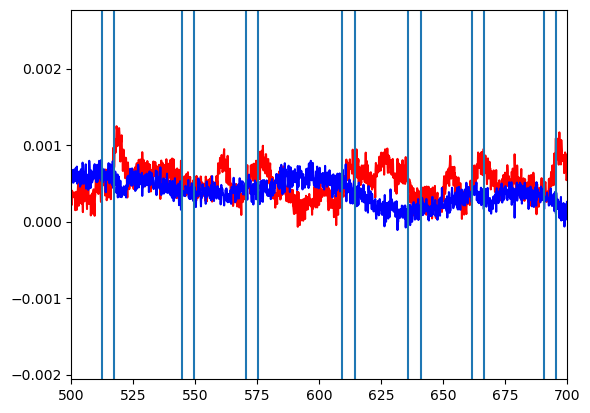

In [27]:
p.plot(conc.time, conc.sel(channel="S5D7", chromo="HbO"), "r-")
p.plot(conc.time, conc.sel(channel="S5D7", chromo="HbR"), "b-")
p.xlim(500,700)
for i, r in stim.iterrows():
    p.axvline(r.onset)
    p.axvline(r.onset+r.duration)

# Frequency Filter

Construct a 4th order Butterworth bandpass filter with $f_{min}=0.02\, \textrm{Hz}$ and $f_{max}=0.5\, \textrm{Hz}$. Use again `xr.apply_ufunc` to apply `scipy.signal.filtfilt` and get a xarray return value.

Again xr.apply_ufunc strips the units

In [28]:
fny = da.cd.sampling_rate/2
b,a = scipy.signal.butter(4, (0.02/fny, 0.5/fny), "bandpass")
conc_filtered = xr.apply_ufunc(scipy.signal.filtfilt, b,a, conc)
conc_filtered

/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/scipy/signal/_signaltools.py:4120: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)


<xarray.DataArray (chromo: 2, channel: 28, time: 23239)>
array([[[ 9.10361248e-05,  1.13866365e-04,  1.35483010e-04, ...,
         -8.30747376e-05, -4.55533127e-05, -6.24081111e-06],
        [ 6.44568058e-05,  8.34945473e-05,  1.01553792e-04, ...,
          4.28055832e-06,  7.50485740e-06,  1.02996415e-05],
        [ 8.64761524e-05,  1.25203867e-04,  1.61250505e-04, ...,
          5.40577520e-06,  1.10033087e-05,  1.57122369e-05],
        ...,
        [ 1.20543327e-04,  1.91560471e-04,  2.57615482e-04, ...,
          2.42331290e-05,  1.09313519e-05, -4.46277268e-06],
        [ 1.52327514e-04,  2.26826455e-04,  2.95773601e-04, ...,
          1.16271282e-05,  3.58485392e-07, -1.26011361e-05],
        [ 7.21561209e-05,  2.35615907e-04,  3.89109203e-04, ...,
          9.50192267e-06,  5.14651976e-06, -1.34712420e-06]],

       [[ 1.29468560e-05,  2.10421449e-05,  2.89232834e-05, ...,
          3.28749948e-05,  2.13536954e-05,  8.57449724e-06],
        [ 1.90340591e-05,  1.29257105e-05,  6.86375978e-06, ...,
         -1.32119068e-05, -1.05338249e-05, -7.68872337e-06],
        [ 5.91855799e-05,  6.17490148e-05,  6.46496675e-05, ...,
         -9.34123641e-06, -1.41893114e-05, -1.88151643e-05],
        ...,
        [ 2.08866560e-06, -3.56667189e-06, -9.03024595e-06, ...,
          4.31275554e-05,  2.70439771e-05,  9.99168079e-06],
        [ 2.40176177e-05,  3.64426793e-05,  4.81422584e-05, ...,
          2.66826538e-05,  2.11020139e-05,  1.49124981e-05],
        [ 3.50679789e-05,  4.15333271e-06, -2.57742287e-05, ...,
          2.67396104e-05,  1.09536657e-05, -5.78922066e-06]]])
Coordinates:
  * chromo    (chromo) <U3 'HbO' 'HbR'
  * time      (time) float64 0.0 0.128 0.256 ... 2.974e+03 2.974e+03 2.974e+03
    samples   (time) int64 0 1 2 3 4 5 6 ... 23233 23234 23235 23236 23237 23238
  * channel   (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
    source    (channel) object 'S1' 'S1' 'S1' 'S1' 'S2' ... 'S7' 'S8' 'S8' 'S8'
    detector  (channel) object 'D1' 'D2' 'D3' 'D9' ... 'D15' 'D7' 'D8' 'D16'

In [53]:
conc_filtered = conc.cd.freq_filter(0.02, 0.5, 4)
conc_filtered

Magnitude,[[[0.09103592215925312 0.11386616024705591 0.1354828034544027 ... -0.08307473082751475 -0.04555330611218955 -0.006240804743985035] [0.06445675875518228 0.08349450183804301 0.10155374790300933 ... 0.004280558021393692 0.007504857229535327 0.010299641409462847] [0.08647630526805392 0.12520402054128524 0.1612506591354561 ... 0.005405768132187568 0.011003301939492432 0.01571223047923599] ... [0.12054347942176001 0.19156062275443286 0.2576156334021592 ... 0.024233137977191548 0.010931360651608258 -0.004462764112980087] [0.1523273637232159 0.22682630258717706 0.29577344715123244 ... 0.0116271388429604 0.0003584958851351487 -0.012601125790125206] [0.07215592852346289 0.23561571759763306 0.3891090165328731 ... 0.009501920509905531 0.005146517515093965 -0.0013471265073122024]] [[0.012946864660966713 0.021042153706019234 0.028923292262210413 ... 0.032874993862048604 0.021353694433923324 0.008574496327318508] [0.0190340447686446 0.012925696101449072 0.006863745359506178 ... -0.013211906486424795 -0.010533824640383202 -0.0076887230610353545] [0.059185584987489825 0.061749019892847465 0.0646496727757652 ... -0.009341234130531785 -0.014189309221520317 -0.01881516210532493] ... [0.0020886541049346006 -0.0035666829354005845 -0.009030256542958933 ... 0.04312755605559141 0.02704397773466396 0.009991681409079856] [0.024017679747304954 0.03644274204047645 0.048142321737612445 ... 0.026682653145120843 0.021102013264075264 0.014912497434908589] [0.03506796635949261 0.004153319893448089 -0.02577424185544091 ... 0.026739609059937955 0.010953664323386226 -0.005789221964034467]]]
Units,micromolar


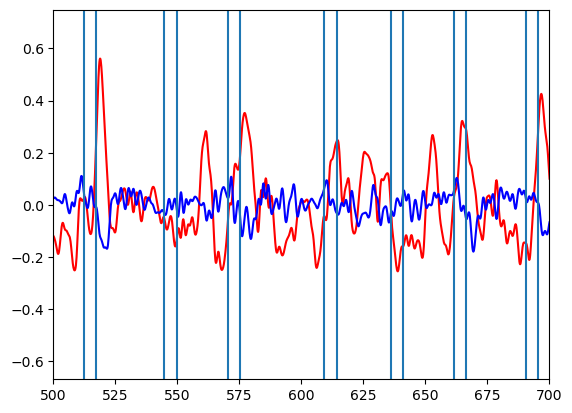

In [60]:
p.plot(conc_filtered.time, conc_filtered.sel(channel="S5D7", chromo="HbO"), "r-")
p.plot(conc_filtered.time, conc_filtered.sel(channel="S5D7", chromo="HbR"), "b-")
p.xlim(500,700)
for i, r in stim.iterrows():
    p.axvline(r.onset)
    p.axvline(r.onset+r.duration)

# Epochs

In [55]:
conc_epochs = conc_filtered.cd.to_epochs(stim, ["Tapping/Left", "Tapping/Right"], before=5, after=20)

In [56]:
conc_epochs

<xarray.DataArray (epoch: 60, chromo: 2, channel: 28, reltime: 196)>
<Quantity([[[[-1.94793222e-02 -1.99498960e-02 -2.09449537e-02 ... -1.93967179e-01
    -2.19295279e-01 -2.45523635e-01]
   [-1.04424529e-02 -1.13746648e-02 -1.28446694e-02 ... -2.53762386e-01
    -2.59976573e-01 -2.64539969e-01]
   [-1.25001014e-02 -8.88962976e-03 -5.84274004e-03 ... -2.11476193e-01
    -2.25564975e-01 -2.39754490e-01]
   ...
   [ 9.56438462e-02  1.00754023e-01  1.04988519e-01 ... -3.29067337e-01
    -3.47020864e-01 -3.64052495e-01]
   [ 2.07332212e-02  2.24040094e-02  2.39323744e-02 ... -2.94619256e-01
    -2.99544793e-01 -3.03712433e-01]
   [ 1.43241419e-03  2.04148421e-03  4.10262597e-03 ... -3.09737050e-01
    -3.27102356e-01 -3.42865738e-01]]

  [[ 1.46411154e-02  6.43012881e-03 -1.68531002e-03 ... -6.53634356e-02
    -6.28387281e-02 -5.72204397e-02]
   [ 2.09503047e-03  5.53133597e-03  8.99825111e-03 ... -4.88580206e-02
    -5.49898557e-02 -6.00702650e-02]
   [ 4.50533966e-02  4.20051097e-02  3.93000498e-02 ... -4.39357317e-02
    -4.30394509e-02 -4.08608676e-02]
...
   [ 2.84544989e-01  2.93238535e-01  3.00156063e-01 ...  1.06173041e-01
     1.13391191e-01  1.21189717e-01]
   [ 3.43061918e-01  3.95920753e-01  4.48093272e-01 ... -1.85776602e-01
    -1.78715676e-01 -1.71418891e-01]
   [ 6.18007698e-01  6.10587057e-01  6.02914720e-01 ...  1.88680410e-01
     1.90028408e-01  1.90763943e-01]]

  [[ 6.51668468e-02  5.74188678e-02  4.91342254e-02 ...  3.15212793e-02
     3.20532998e-02  3.17599159e-02]
   [ 3.68453102e-02  3.46997250e-02  3.14498120e-02 ... -3.04468396e-02
    -2.76769777e-02 -2.38675959e-02]
   [ 4.88877816e-02  3.99800292e-02  3.27429305e-02 ...  3.03869796e-02
     3.48244640e-02  3.96304442e-02]
   ...
   [ 5.81742727e-02  5.31069953e-02  4.77391187e-02 ... -8.13634832e-03
    -6.29604474e-03 -5.30396241e-03]
   [ 1.51541165e-01  1.62022806e-01  1.72986055e-01 ...  2.61859742e-02
     3.29919224e-02  3.88587009e-02]
   [ 1.59376150e-01  1.53478141e-01  1.46873280e-01 ...  3.82218417e-02
     4.28325223e-02  4.67744301e-02]]]], 'micromolar')>
Coordinates:
  * chromo      (chromo) <U3 'HbO' 'HbR'
  * channel     (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
    source      (channel) object 'S1' 'S1' 'S1' 'S1' ... 'S7' 'S8' 'S8' 'S8'
    detector    (channel) object 'D1' 'D2' 'D3' 'D9' ... 'D15' 'D7' 'D8' 'D16'
  * reltime     (reltime) float64 -4.992 -4.864 -4.736 ... 19.71 19.84 19.97
    trial_type  (epoch) object 'Tapping/Left' 'Tapping/Left' ... 'Tapping/Right'
Dimensions without coordinates: epoch

# Block averages

To calculate average responses we need to calculate the baseline before each stimulus and subtract it. The time samples beloning to the baseline are easily selected by `conc_epochs.reltime < 0`

In [61]:
baseline = conc_epochs.sel(reltime=(conc_epochs.reltime < 0)).mean("reltime")
conc_epochs_blcorrected = conc_epochs - baseline

Now all epochs belonging to a trial_type need to be grouped and averaged. Xarray's `groupby` operation makes that easy:

In [62]:
blockaverage = conc_epochs_blcorrected.groupby("trial_type").mean("epoch")
blockaverage

Magnitude,[[[[-0.053986948274251725 -0.05393474339757285 -0.05397982130119917 ... 0.0770272130301187 0.07334362846569646 0.06958860385276933] [-0.03761206604055816 -0.036605713862035066 -0.035606487239280143 ... 0.01757105989178187 0.015984742225484166 0.014144480817071226] [-0.04838998567182547 -0.04678443107028674 -0.04489915095890643 ... 0.027615004854258548 0.02572158839730453 0.023575626581218277] ... [-0.04206262552774646 -0.04082646928799954 -0.03934513745556607 ... 0.034287460805260635 0.030989599556957778 0.02737642767782292] [-0.030618267637786876 -0.028919014199497817 -0.02817655889487196 ... 0.025227151689982366 0.02696165925438884 0.02836726192096361] [-0.061406360335975275 -0.058302766568549186 -0.054724914804163055 ... -0.012883664825033943 -0.015950461727736114 -0.01935921841621022]] [[-0.0075736658429331844 -0.007562497936053282 -0.007333211574814815 ... -0.008943154317287353 -0.008582645507960512 -0.008033991520398935] [-0.004080115244913801 -0.003947431421026102 -0.003994643280808594 ... -0.01303390621388518 -0.01358088414148014 -0.013652186949715758] [-8.388441729468577e-05 -0.0007377618546425324 -0.0014917401174174166 ... -0.0051805240387389866 -0.005081533688889643 -0.004900212345999287] ... [-0.003955775480278912 -0.0027311319520516146 -0.0015540447331885787 ... -0.02695979902863633 -0.026415189947603168 -0.025959597766996866] [-0.011951325874742506 -0.010511936228787636 -0.009579582861805248 ... 0.008503896629678258 0.008042664762421468 0.007409770549404804] [-0.013077128934981301 -0.010855845949919276 -0.008589609520045057 ... -0.022998181194775293 -0.02406456807845843 -0.025008879988848397]]] [[[-0.025519659925409142 -0.02373314262223629 -0.022093813288720468 ... -0.015779418757908007 -0.021393776125318915 -0.026861971920205688] [-0.03784911865647192 -0.03455087245723531 -0.030608048265152128 ... -0.02889876614947238 -0.031182288228843797 -0.033042247064142084] [-0.025030697840990428 -0.023032234036877042 -0.020816080873767365 ... -0.03190319284018016 -0.03451616090387382 -0.03673395884987296] ... [-0.024863992693320586 -0.021556850924600135 -0.01836481913615865 ... -0.03738665603406189 -0.04137110363644152 -0.04537323742577581] [0.010941854046110183 0.012628896008953979 0.013829288475429627 ... -0.14919946784976387 -0.15682492863728176 -0.16453954290346864] [-0.027592310784294753 -0.02403426686734828 -0.020469800140929997 ... -0.038756334243596355 -0.0425836430421985 -0.04632135093169546]] [[-0.002424050186485414 -0.0024723183484888158 -0.0021930329357036493 ... 0.00995276743999039 0.009352640150801485 0.008530671879958911] [0.00038571809782161415 0.0002591970261750323 -9.317931263894026e-05 ... 0.0013926346034655581 0.00047064587507627864 -0.0009338120314738494] [-0.00429888327242561 -0.004723091270383829 -0.004889163314584441 ... 0.01027173342383867 0.009587691423250404 0.008624420307305026] ... [-0.0031692193640315363 -0.0038205237805649566 -0.004337791757881546 ... 0.0033343728423846923 0.0042991759538563885 0.005106292677363094] [0.014811300800233712 0.013937163958676802 0.01303924396382757 ... -0.009078511262006842 -0.013556648756520923 -0.01809148218378138] [-0.0008636597353152628 -0.0005758631524040635 -0.0005232884612616062 ... -0.005361941486270629 -0.0059910300626701265 -0.007053680161982997]]]]
Units,micromolar


### Plot the results

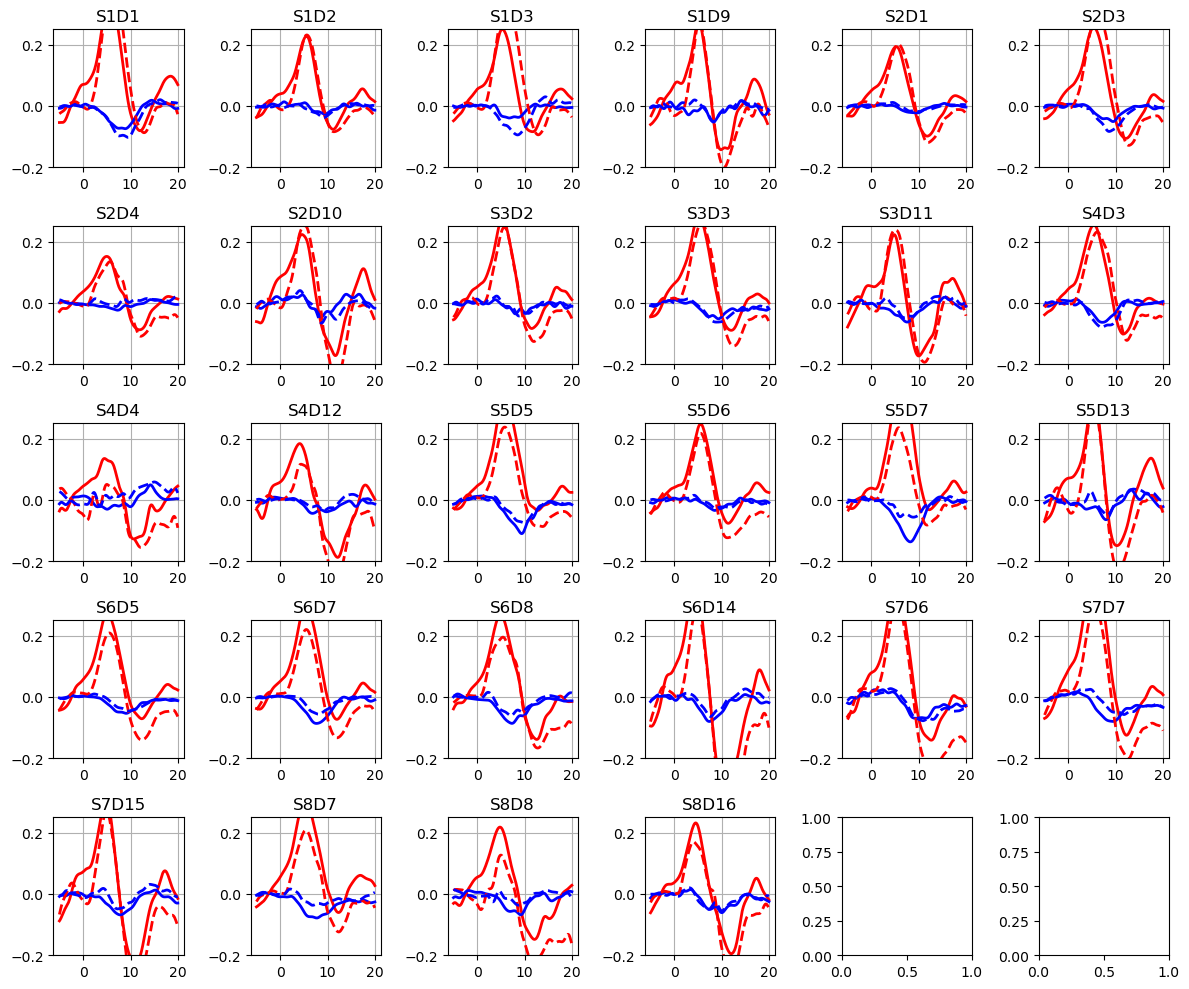

In [64]:
f,ax = p.subplots(5,6, figsize=(12,10))
ax = ax.flatten()
for i_ch, ch in enumerate(conc_epochs_blcorrected.channel):
    for ls, trial_type in zip(["-", "--"], blockaverage.trial_type):
        #for i_epoch in range(epochs.shape[0]):
        #    ax[i_ch].plot(conc_epochs_blcorrected.reltime, conc_epochs_blcorrected.loc[i_epoch, "HbO", ch, :], "r-", alpha=.1)
        #    ax[i_ch].plot(conc_epochs_blcorrected.reltime, conc_epochs_blcorrected.loc[i_epoch, "HbR", ch, :], "b-", alpha=.1)
    
        ax[i_ch].plot(blockaverage.reltime, blockaverage.sel(chromo="HbO", trial_type=trial_type, channel=ch), "r", lw=2, ls=ls)
        ax[i_ch].plot(blockaverage.reltime, blockaverage.sel(chromo="HbR", trial_type=trial_type, channel=ch), "b", lw=2, ls=ls)
        ax[i_ch].grid(1)
        ax[i_ch].set_title(ch.values)
        ax[i_ch].set_ylim(-.2, .25)
    
p.tight_layout()

# sklearn
Evaluate the interplay of xarray and sklearn

In [65]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score

Start from baseline-corrected, epoched concentration data. 

In [66]:
conc_epochs_blcorrected

<xarray.DataArray (epoch: 60, chromo: 2, channel: 28, reltime: 196)>
<Quantity([[[[ 1.05512128e-01  1.05041554e-01  1.04046496e-01 ... -6.89757291e-02
    -9.43038289e-02 -1.20532185e-01]
   [ 9.14562420e-02  9.05240301e-02  8.90540255e-02 ... -1.51863691e-01
    -1.58077878e-01 -1.62641274e-01]
   [ 6.64808427e-02  7.00913143e-02  7.31382040e-02 ... -1.32495249e-01
    -1.46584031e-01 -1.60773546e-01]
   ...
   [ 7.48773986e-02  7.99875755e-02  8.42220717e-02 ... -3.49833785e-01
    -3.67787312e-01 -3.84818942e-01]
   [ 5.06994375e-02  5.23702257e-02  5.38985907e-02 ... -2.64653040e-01
    -2.69578577e-01 -2.73746217e-01]
   [ 5.23628474e-02  5.29719174e-02  5.50330592e-02 ... -2.58806617e-01
    -2.76171923e-01 -2.91935304e-01]]

  [[ 2.89606602e-03 -5.31492053e-03 -1.34303594e-02 ... -7.71084850e-02
    -7.45837774e-02 -6.89654890e-02]
   [-4.05151445e-03 -6.15208956e-04  2.85170619e-03 ... -5.50045655e-02
    -6.11364006e-02 -6.62168100e-02]
   [ 7.61725320e-03  4.56896622e-03  1.86390633e-03 ... -8.13718751e-02
    -8.04755943e-02 -7.82970110e-02]
...
   [ 1.55331352e-01  1.64024898e-01  1.70942426e-01 ... -2.30405965e-02
    -1.58224459e-02 -8.02391992e-03]
   [-4.30036297e-01 -3.77177462e-01 -3.25004943e-01 ... -9.58874818e-01
    -9.51813892e-01 -9.44517106e-01]
   [ 3.10325614e-01  3.02904973e-01  2.95232636e-01 ... -1.19001674e-01
    -1.17653675e-01 -1.16918141e-01]]

  [[ 4.14962698e-02  3.37482909e-02  2.54636484e-02 ...  7.85070226e-03
     8.38272284e-03  8.08933895e-03]
   [ 3.37429606e-02  3.15973754e-02  2.83474624e-02 ... -3.35491892e-02
    -3.07793273e-02 -2.69699455e-02]
   [ 4.21731148e-03 -4.69044100e-03 -1.19275397e-02 ... -1.42834906e-02
    -9.84600618e-03 -5.04002592e-03]
   ...
   [ 1.55581286e-02  1.04908512e-02  5.12297456e-03 ... -5.07524924e-02
    -4.89121889e-02 -4.79201065e-02]
   [-5.86544660e-02 -4.81728246e-02 -3.72095755e-02 ... -1.84009657e-01
    -1.77203708e-01 -1.71336930e-01]
   [ 8.37683294e-02  7.78703198e-02  7.12654593e-02 ... -3.73859790e-02
    -3.27752984e-02 -2.88333906e-02]]]], 'micromolar')>
Coordinates:
  * chromo      (chromo) <U3 'HbO' 'HbR'
  * channel     (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
    source      (channel) object 'S1' 'S1' 'S1' 'S1' ... 'S7' 'S8' 'S8' 'S8'
    detector    (channel) object 'D1' 'D2' 'D3' 'D9' ... 'D15' 'D7' 'D8' 'D16'
  * reltime     (reltime) float64 -4.992 -4.864 -4.736 ... 19.71 19.84 19.97
    trial_type  (epoch) object 'Tapping/Left' 'Tapping/Left' ... 'Tapping/Right'
Dimensions without coordinates: epoch

We don't need the baseline samples so remove them:

In [67]:
conc_epochs_blcorrected_nobl = conc_epochs_blcorrected.sel(reltime=conc_epochs_blcorrected.reltime >=0)
conc_epochs_blcorrected_nobl

<xarray.DataArray (epoch: 60, chromo: 2, channel: 28, reltime: 157)>
<Quantity([[[[-3.62704424e-02 -1.80644642e-02  2.04713173e-03 ... -6.89757291e-02
    -9.43038289e-02 -1.20532185e-01]
   [ 4.64746889e-03  1.18372717e-02  1.90967821e-02 ... -1.51863691e-01
    -1.58077878e-01 -1.62641274e-01]
   [ 2.44962473e-03  1.22943870e-02  2.38491981e-02 ... -1.32495249e-01
    -1.46584031e-01 -1.60773546e-01]
   ...
   [-4.34500183e-02 -3.09090823e-02 -1.62012415e-02 ... -3.49833785e-01
    -3.67787312e-01 -3.84818942e-01]
   [ 2.29520360e-02  3.45238453e-02  4.66219287e-02 ... -2.64653040e-01
    -2.69578577e-01 -2.73746217e-01]
   [-4.25566302e-03  1.39526964e-02  3.32256774e-02 ... -2.58806617e-01
    -2.76171923e-01 -2.91935304e-01]]

  [[ 1.59138946e-02  1.39439720e-02  1.09250913e-02 ... -7.71084850e-02
    -7.45837774e-02 -6.89654890e-02]
   [-1.29157910e-02 -9.43263594e-03 -4.72850583e-03 ... -5.50045655e-02
    -6.11364006e-02 -6.62168100e-02]
   [-6.13908746e-03 -2.17261918e-03 -2.95636182e-05 ... -8.13718751e-02
    -8.04755943e-02 -7.82970110e-02]
...
   [-2.52666106e-01 -2.56312787e-01 -2.58763874e-01 ... -2.30405965e-02
    -1.58224459e-02 -8.02391992e-03]
   [-1.43161314e-01 -1.69394654e-01 -1.95283656e-01 ... -9.58874818e-01
    -9.51813892e-01 -9.44517106e-01]
   [-3.23421994e-01 -3.32682530e-01 -3.41847469e-01 ... -1.19001674e-01
    -1.17653675e-01 -1.16918141e-01]]

  [[-3.27025440e-02 -3.05549088e-02 -2.65252812e-02 ...  7.85070226e-03
     8.38272284e-03  8.08933895e-03]
   [-1.91871158e-02 -1.63869507e-02 -1.33339973e-02 ... -3.35491892e-02
    -3.07793273e-02 -2.69699455e-02]
   [-2.83744300e-02 -2.60873624e-02 -2.42768347e-02 ... -1.42834906e-02
    -9.84600618e-03 -5.04002592e-03]
   ...
   [ 1.27008107e-03 -2.55851076e-03 -5.81829740e-03 ... -5.07524924e-02
    -4.89121889e-02 -4.79201065e-02]
   [-1.09177738e-01 -1.12308823e-01 -1.15386399e-01 ... -1.84009657e-01
    -1.77203708e-01 -1.71336930e-01]
   [-7.08732863e-02 -7.43227279e-02 -7.63499322e-02 ... -3.73859790e-02
    -3.27752984e-02 -2.88333906e-02]]]], 'micromolar')>
Coordinates:
  * chromo      (chromo) <U3 'HbO' 'HbR'
  * channel     (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
    source      (channel) object 'S1' 'S1' 'S1' 'S1' ... 'S7' 'S8' 'S8' 'S8'
    detector    (channel) object 'D1' 'D2' 'D3' 'D9' ... 'D15' 'D7' 'D8' 'D16'
  * reltime     (reltime) float64 0.0 0.128 0.256 0.384 ... 19.71 19.84 19.97
    trial_type  (epoch) object 'Tapping/Left' 'Tapping/Left' ... 'Tapping/Right'
Dimensions without coordinates: epoch

In [40]:
conc_epochs_blcorrected_nobl.channel

<xarray.DataArray 'channel' (channel: 28)>
array(['S1D1', 'S1D2', 'S1D3', 'S1D9', 'S2D1', 'S2D3', 'S2D4', 'S2D10', 'S3D2',
       'S3D3', 'S3D11', 'S4D3', 'S4D4', 'S4D12', 'S5D5', 'S5D6', 'S5D7',
       'S5D13', 'S6D5', 'S6D7', 'S6D8', 'S6D14', 'S7D6', 'S7D7', 'S7D15',
       'S8D7', 'S8D8', 'S8D16'], dtype=object)
Coordinates:
  * channel   (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
    source    (channel) object 'S1' 'S1' 'S1' 'S1' 'S2' ... 'S7' 'S8' 'S8' 'S8'
    detector  (channel) object 'D1' 'D2' 'D3' 'D9' ... 'D15' 'D7' 'D8' 'D16'

sklearn estimator and transforms expect datasets in the form of an 2D array X with shape (n_samples, n_features). We can transform our 4D DataArray into this shape by stacking 3 dimensions together. Also create an index for the epoch dimension, which did not have one so far.

In [41]:
X = conc_epochs_blcorrected_nobl.stack(features=["chromo", "channel", "reltime"])
X = X.set_xindex("trial_type")
X

Magnitude,[[-0.00010598228230380903 -0.00010211474903042183 0.00010806541014250304 ... -0.00016274938222618105 -0.00014013696647889118 -9.623549059898122e-05] [0.00017730785535886937 0.00010200083434924517 0.00012898990644518858 ... -0.00013645724478356124 -0.00011968277531564943 -0.00010367717481580131] [2.023056821418229e-05 0.00011464563304326041 9.94896641669291e-05 ... -0.00017888294280418628 -0.00016685137860763199 -0.00010885429790215284] ... [-8.999018244771869e-05 -1.5772308418072166e-05 -3.8263315200577305e-06 ... -0.00010366353979862468 -0.0001797775718143629 -6.284422291709857e-05] [5.077885709792347e-05 0.00022416775007193037 0.00018802492225234913 ... -0.0002079807273469885 -0.00027301131760265856 -0.0002777209615785083] [-0.00032961860707408897 -0.0002899087914915123 -0.00017370967160101647 ... -2.717179279816608e-05 -6.524295964273699e-05 -5.4862247375564834e-05]]
Units,millimeter molar/meter


For a classification taks we need an array with class labels, typically called `y`. We can use sklearn's LabelEncoder to derive labels from the trial_type coordinates:

In [42]:
y = xr.apply_ufunc(LabelEncoder().fit_transform, X.trial_type)

In [43]:
display(y)
display(y.sel(trial_type="Tapping/Left"))
display(y.sel(trial_type="Tapping/Right"))

<xarray.DataArray 'trial_type' (epoch: 60)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
  * trial_type  (epoch) object 'Tapping/Left' 'Tapping/Left' ... 'Tapping/Right'
Dimensions without coordinates: epoch

<xarray.DataArray 'trial_type' (epoch: 30)>
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * trial_type  (epoch) object 'Tapping/Left' 'Tapping/Left' ... 'Tapping/Left'
Dimensions without coordinates: epoch

<xarray.DataArray 'trial_type' (epoch: 30)>
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
  * trial_type  (epoch) object 'Tapping/Right' ... 'Tapping/Right'
Dimensions without coordinates: epoch

Sklearn's train_test_split works on xarrays and does return xarrays. 

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

In [45]:
display(X_train.groupby("trial_type").count().rename("train"))
display(X_test.groupby("trial_type").count().rename("test"))

<xarray.DataArray 'train' (trial_type: 2, features: 8792)>
array([[21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21]])
Coordinates:
    source      (features) object 'S1' 'S1' 'S1' 'S1' ... 'S8' 'S8' 'S8' 'S8'
    detector    (features) object 'D1' 'D1' 'D1' 'D1' ... 'D16' 'D16' 'D16'
  * features    (features) object MultiIndex
  * chromo      (features) <U3 'HbO' 'HbO' 'HbO' 'HbO' ... 'HbR' 'HbR' 'HbR'
  * channel     (features) object 'S1D1' 'S1D1' 'S1D1' ... 'S8D16' 'S8D16'
  * reltime     (features) float64 0.0 0.128 0.256 0.384 ... 19.71 19.84 19.97
  * trial_type  (trial_type) object 'Tapping/Left' 'Tapping/Right'

<xarray.DataArray 'test' (trial_type: 2, features: 8792)>
array([[9, 9, 9, ..., 9, 9, 9],
       [9, 9, 9, ..., 9, 9, 9]])
Coordinates:
    source      (features) object 'S1' 'S1' 'S1' 'S1' ... 'S8' 'S8' 'S8' 'S8'
    detector    (features) object 'D1' 'D1' 'D1' 'D1' ... 'D16' 'D16' 'D16'
  * features    (features) object MultiIndex
  * chromo      (features) <U3 'HbO' 'HbO' 'HbO' 'HbO' ... 'HbR' 'HbR' 'HbR'
  * channel     (features) object 'S1D1' 'S1D1' 'S1D1' ... 'S8D16' 'S8D16'
  * reltime     (features) float64 0.0 0.128 0.256 0.384 ... 19.71 19.84 19.97
  * trial_type  (trial_type) object 'Tapping/Left' 'Tapping/Right'

Train a LDA classifier and use it to predict labels. We need to use `xr.apply_ufunc` if we want to have an xarray.

In [46]:
clf = LinearDiscriminantAnalysis(n_components=1).fit(X_train, y_train)

/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


In [47]:
y_pred = xr.apply_ufunc(clf.predict, X_test, input_core_dims=[["features"]])

/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/sklearn/utils/_array_api.py:185: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


In [48]:
accuracy_score(y_test, y_pred)

0.6666666666666666

The advantage here is that when X and y are still xarrays we still have access to the coordinate axes. That means for example, that we can still use them to select samples:

/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


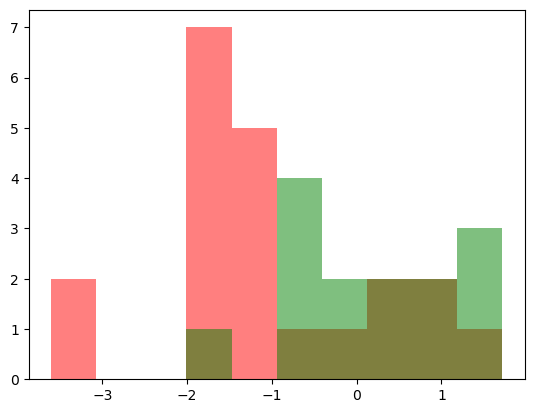

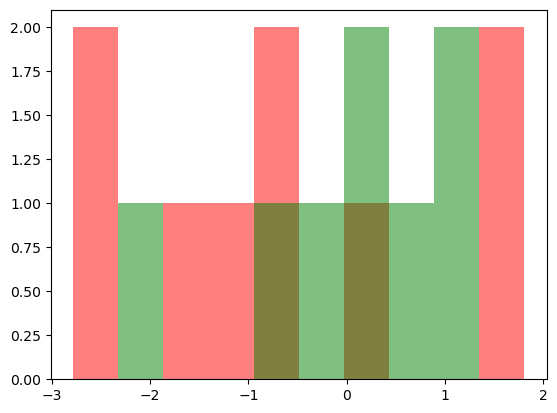

In [49]:
p.figure()
bincount, bins, _ = p.hist(clf.decision_function(X_train.sel(trial_type="Tapping/Left")), alpha=.5, fc="r")
bincount, bins, _ = p.hist(clf.decision_function(X_train.sel(trial_type="Tapping/Right")), bins, alpha=.5, fc="g")

p.figure()
bincount, bins, _ = p.hist(clf.decision_function(X_test.sel(trial_type="Tapping/Left")), alpha=.5, fc="r")
bincount, bins, _ = p.hist(clf.decision_function(X_test.sel(trial_type="Tapping/Right")), bins, alpha=.5, fc="g")



Finally, test to use cross-validation while training our classifier:

In [50]:
cross_validate(clf, X,y)

/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/opt/miniconda3/envs/cedalion/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(d

{'fit_time': array([0.65585113, 0.54266739, 0.71796107, 0.5081892 , 0.78546333]),
 'score_time': array([0.00612688, 0.014431  , 0.00828218, 0.01657701, 0.01299524]),
 'test_score': array([0.75      , 0.58333333, 0.75      , 0.5       , 0.91666667])}